#*Intel Image Classification*

Steps in this project:

1.   Create a DataFrame having pathnames and label of images
2.   Preprocessing the images
3.   Creating batches for the model
4.   Building the model
5.   Fine tuning the pre-trained model on our dataset
6.   Check the prediction accuracy



###Import the required libraries

In [1]:
import pandas as pd
from tensorflow import keras
import numpy as np
import tensorflow_hub as hub
import os
import tensorflow as tf
import random
import pickle
from IPython.display import display, Image




###Model url for the model

In [2]:
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"
INPUT_SHAPE=(None,224,224,3);
OUTPUT_SHAPE=6;

###Create pathnames and label using os library

In [3]:

categories=np.array(["buildings","forest","glacier","mountain","sea","street"])
count=0

filenames=pd.DataFrame(columns=["path","label"])

for ele in categories:
  filenames_temp = ["drive/My Drive/Machine Learning/intel_image/seg_train/seg_train/" + ele+"/"+ fname  for fname in os.listdir("drive/My Drive/Machine Learning/intel_image/seg_train/seg_train/"+ele+"/")]
  filenames_temp=pd.DataFrame(filenames_temp)
  filenames_temp["label"]=count
  filenames_temp.rename(columns={0:"path"},inplace=True)
  count+=1
  filenames=pd.concat([filenames,filenames_temp],ignore_index=True)


In [4]:
#filenames.head()["path"]
print(filenames.loc[42]["path"])
print(filenames.loc[42]["label"])

drive/My Drive/Machine Learning/intel_image/seg_train/seg_train/buildings/8577.jpg
0


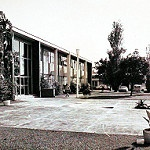

In [5]:
Image(filenames.loc[42]["path"])

In [6]:
categories=np.array(["buildings","forest","glacier","mountain","sea","street"])

filenames_testval=pd.DataFrame(columns=["path","label"])
count=0

for ele in categories:

  filenames_temp = ["drive/My Drive/Machine Learning/intel_image/seg_test/seg_test/" + ele+"/"+fname  for fname in os.listdir("drive/My Drive/Machine Learning/intel_image/seg_test/seg_test/"+ele+"/")]
  filenames_temp=pd.DataFrame(filenames_temp)
  filenames_temp["label"]=count
  filenames_temp.rename(columns={0:"path"},inplace=True)
  count=count+1
  filenames_testval=pd.concat([filenames_testval,filenames_temp],ignore_index=True)

drive/My Drive/Machine Learning/intel_image/seg_test/seg_test/street/22408.jpg
5


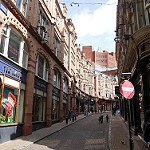

In [7]:
print(filenames_testval['path'][1099])
print(filenames_testval['label'][1099])

Image(filenames_testval['path'][1099])

In [8]:
from sklearn.model_selection import train_test_split

In [9]:

X_Combine=filenames_testval["path"]

Y_Combine=filenames_testval["label"]

X_val, X_test, Y_val, Y_test = train_test_split(X_Combine,
                                                Y_Combine,
                                                test_size=0.5,
                                                random_state=42)
X_val=X_val.to_list()
Y_val=Y_val.to_list()

X_test=X_test.to_list()
Y_test=Y_test.to_list()


In [10]:
#taking part of data to reduce training time
filenames=filenames.sample(frac=0.5)

X=filenames["path"]
Y=filenames["label"]

X=X.to_list()
Y=Y.to_list()

### Function for pre-processing the images using tensorflow

In [11]:

# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """

  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image


In [12]:
def get_image_label(image_path, label):

  image = process_image(image_path)
  return image, label

### Function to create batches for training

In [13]:
BATCH_SIZE=32

# Create a function to turn data into batches
def create_data_batches(x, y, batch_size=BATCH_SIZE, validation_data=False, test_data=False):


  # In validation dataset we do shuffle labels.
  if validation_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepaths
                                               tf.constant(y))) # labels
    data = data.shuffle(buffer_size=len(x))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If the data if a test dataset, we don't need to shuffle it as we will check the accuracy using it.
  elif test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels

    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)


    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    data = data.shuffle(buffer_size=len(x))
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

###Creating batches...

In [14]:

train_dataset=create_data_batches(X,Y)
validation_dataset=create_data_batches(X_val,Y_val,validation_data=True)
test_dataset=create_data_batches(X_test,Y_test,test_data=True)


Creating training data batches...
Creating validation data batches...
Creating test data batches...


###Create the model

In [15]:

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dropout(0.3), #Layer 2(dropout layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 3 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

In [16]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              2555993   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 6)                 6012      
                                                                 
Total params: 2,562,005
Trainable params: 6,012
Non-trainable params: 2,555,993
_________________________________________________________________


### Creating the model

In [19]:
history=model.fit(train_dataset, epochs=20)
#we executed the training without validation dataset because it was taking too long even on gpu(google colab)

Epoch 1/20
220/220 [==============================] - 323s 1s/step - loss: 0.3215 - accuracy: 0.8875
Epoch 2/20
220/220 [==============================] - 16s 72ms/step - loss: 0.2858 - accuracy: 0.8988
Epoch 3/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2576 - accuracy: 0.9082
Epoch 4/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2397 - accuracy: 0.9141
Epoch 5/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2321 - accuracy: 0.9163
Epoch 6/20
220/220 [==============================] - 16s 72ms/step - loss: 0.2240 - accuracy: 0.9194
Epoch 7/20
220/220 [==============================] - 16s 70ms/step - loss: 0.2183 - accuracy: 0.9244
Epoch 8/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2152 - accuracy: 0.9184
Epoch 9/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2148 - accuracy: 0.9205
Epoch 10/20
220/220 [==============================] - 16s 71ms/step - loss: 0.2092

In [20]:
history.history

{'loss': [0.32146769762039185,
  0.28577253222465515,
  0.257553368806839,
  0.23974131047725677,
  0.2320767343044281,
  0.22397370636463165,
  0.21834826469421387,
  0.21522673964500427,
  0.21484144032001495,
  0.20920690894126892,
  0.20743098855018616,
  0.1981435865163803,
  0.20855076611042023,
  0.20257556438446045,
  0.19313567876815796,
  0.19793161749839783,
  0.19340185821056366,
  0.19220729172229767,
  0.1858021467924118,
  0.19779060781002045],
 'accuracy': [0.887546181678772,
  0.8987773656845093,
  0.908160388469696,
  0.9141313433647156,
  0.9162638783454895,
  0.9193915128707886,
  0.924367368221283,
  0.9183963537216187,
  0.9205288887023926,
  0.9247938394546509,
  0.9229456782341003,
  0.9257889986038208,
  0.923372209072113,
  0.9249359965324402,
  0.9283480048179626,
  0.9225192070007324,
  0.929627537727356,
  0.9269263744354248,
  0.9283480048179626,
  0.9259312152862549]}

##Evaluate the Model

##Predict the lables

In [22]:
predictions = model.predict(test_dataset, verbose=1)
predictions



21/21 [==============================] - 222s 10s/step


array([[5.28621161e-03, 6.39332120e-06, 3.85731037e-05, 3.85707135e-05,
        2.38208798e-07, 9.94629979e-01],
       [1.01155259e-04, 2.62816884e-05, 1.93287298e-01, 8.04363191e-01,
        2.18763179e-03, 3.44215914e-05],
       [9.91151907e-08, 5.18444665e-07, 2.86480617e-02, 9.71343517e-01,
        7.73900865e-06, 1.11938611e-07],
       ...,
       [1.11237824e-07, 1.28263775e-06, 1.36076560e-04, 7.28730884e-05,
        9.99789655e-01, 1.62964540e-08],
       [1.80555304e-07, 2.78704010e-06, 8.01302784e-04, 5.07768573e-06,
        9.99190390e-01, 1.96705130e-07],
       [1.17010350e-04, 3.78601511e-10, 1.95324059e-08, 2.10402296e-09,
        4.47026610e-10, 9.99882936e-01]], dtype=float32)

In [23]:
predictions.shape[0]

643

In [24]:

length=predictions.shape[0]
int_pred=np.zeros(length)

i=0
for l in predictions:
  int_pred[i]=np.argmax(l)
  i+=1
  #print(np.argmax(l))
int_pred=int_pred.astype('int64')

### Checking accuracy of the predictions

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(int_pred,Y_test)

0.9362363919129082

In [32]:
for i in range(200,210):

  print("True Label:",Y_test[i])
  print("Predicted Label:",int_pred[i])

True Label: 3
Predicted Label: 3
True Label: 5
Predicted Label: 5
True Label: 3
Predicted Label: 3
True Label: 1
Predicted Label: 1
True Label: 5
Predicted Label: 5
True Label: 5
Predicted Label: 5
True Label: 5
Predicted Label: 5
True Label: 3
Predicted Label: 3
True Label: 2
Predicted Label: 2
True Label: 4
Predicted Label: 4


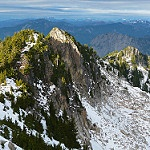

In [31]:
Image(X_test[200])